# Scikit-multiflow

`scikit-multiflow` is an open source framework for multi-output/multi-label and stream data mining. It is being developed by  **Télécom ParisTech** and  **École Polytechique**. 
For this lab we will be using `scikit-multiflow`. Visit the page of the [framework](https://scikit-multiflow.github.io/) and follow the [installation guidelines](https://scikit-multiflow.github.io/scikit-multiflow/installation.html).
**Notice:** `scikit-multiflow` requires `NumPy`
Also, for this lab you will need: `pandas` and `matplotlib`.

# Classification in Data Streams

The goal of this lab is to build a classifier capable of learning and making predictions in a datastream using the `scikit-multiflow` framework. In this lab we are comparing three datastream classifiers on Electricity dataset:
- kNN
- Hoeffding Tree
- Batch-Incremental Ensemble Classifier (BIE)

The last of the three classifiers is not implemented yet. This is the task of this lab. You should implement the `predict` and `partial_fit` functions in the `BatchClassifier` class. Implement a tumbling window of size 100, creating and maintaining up to a maximum of 100 models. Build a `DecisionTreeClassifier` on each of the batches/windows.

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import copy

class BatchClassifier:

    def __init__(self, base_model = DecisionTreeClassifier(), window_size=100, max_models=100, classes=[]):
        """ Batch-Incremental Ensemble Classifier.
        
        
        
        Parameters
        ----------
        base_model: sklearn model - Base learner, each model is a copy of this one.

        window_size (int) - the size of training window - number of observations used to train each model
        
        max_models (int) - Maximum number of models in the ensemble.
      
        classes (list[label]) - List of labels - for Multiclass classification
        
        """
        
        self.H = []
        self.window_size = window_size
        self.max_models = max_models
        self.base_model = base_model
        
        self.X_batch = []
        self.y_batch = []
        
        # Encode the classes
        self.classes = classes
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(classes)
        self.encoded_classes = self.label_encoder.transform(classes)
        
    
    def partial_fit(self, X, y=None, classes=None):
        N, D = X.shape
        
        # Encode y
        encoded_y = self.label_encoder.transform(y)
        
        # Compute the number of windows
        for i in range(N):
            
            # add observation to the window
            self.X_batch.append(X[i])
            self.y_batch.append(encoded_y[i])
        
            if len(self.y_batch) == self.window_size:
                # if the window is full
            
                if len(self.H) >= self.max_models:
                    # Remove the oldest model if the number of models is more than max_models
                    self.H.pop(0)

                # Create a new model
                h = copy.deepcopy(self.base_model)

                # Train the new model
                h.fit(X=self.X_batch, y=self.y_batch)

                # Add the trained model
                self.H.append(h)
                
                # Empty the window
                self.X_batch = []
                self.y_batch = []
            
        return self
    
    def predict_proba(self, X):
        N, D = X.shape
        total_votes = np.zeros((N, len(self.encoded_classes)))
        
        # Add the prediction from all models
        for h in self.H:
            # predict the probability using each model
            y_predict = h.predict_proba(X)

            # Because there could be the case only some classes available in the window
            # We add only the probabilies of the classses existed in the window
            local_classes = h.classes_
            for i in range(len(local_classes)):
                total_votes[:, local_classes[i]] += y_predict[:, i]
                
        return total_votes 

    
    def predict(self, X):
        y_prob_predict = self.predict_proba(X)
        
        # Get the class with the maximum probabilies
        y_index_predict = np.argmax(y_prob_predict, axis=1)
        y_predict = [self.encoded_classes[index] for index in y_index_predict]
        
        # decode the labels to original classes
        return self.label_encoder.inverse_transform(y_predict)


## Evaluation

The following piece of code evaluates the three classifiers and gives the online visualization. It computes the current and global values for `accuracy` and `kappa`. Current value of selected evaluation measure represents the performance of the model on the current window and global value represents the performance of the model on whole datastream. `EvaluatePrequential` also gives the summary of evaluation showing the `Evaluation Time`. It, also, writes the metrics data into a file `result_elec.csv` which will be used in the next part to generate plots for comparing current and global performance of the classifiers.

<IPython.core.display.Javascript object>


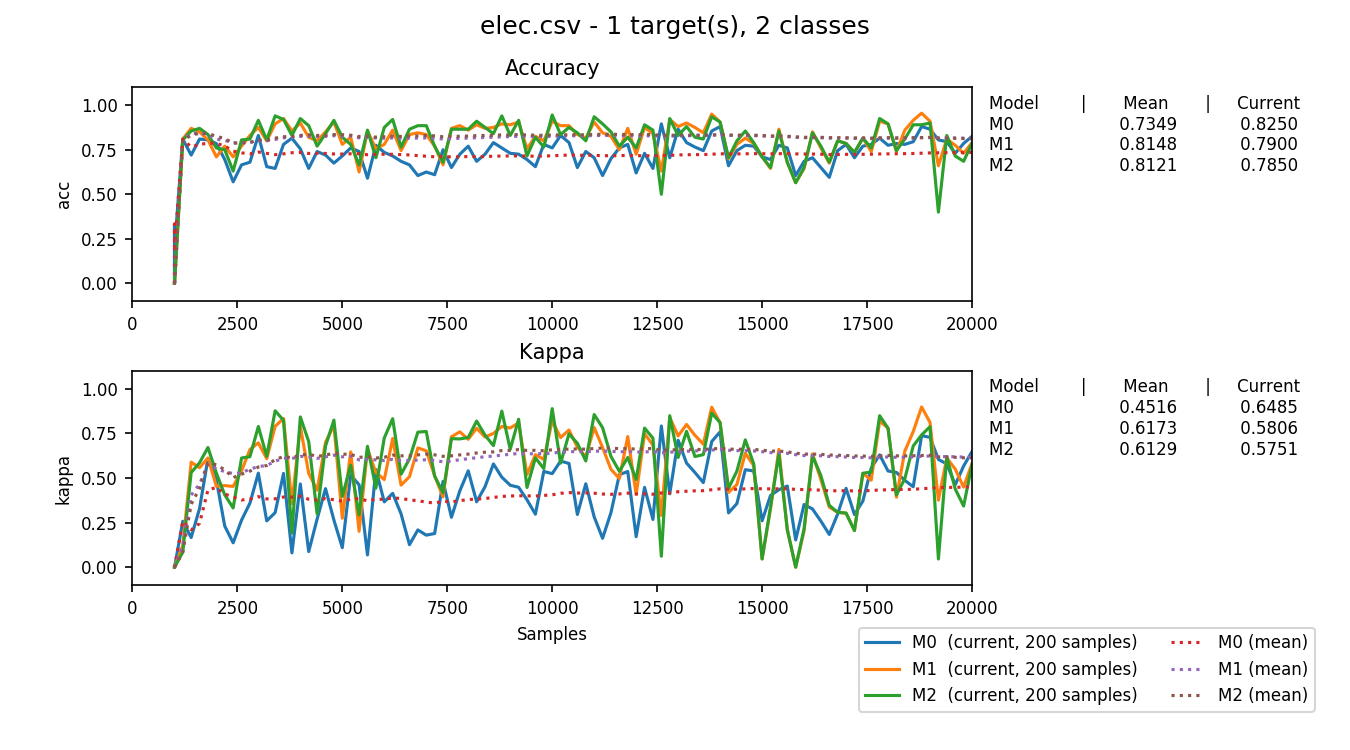

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [99.53s]
Processed samples: 20000
Mean performance:
M0 - Accuracy     : 0.7349
M0 - Kappa        : 0.4516
M1 - Accuracy     : 0.8148
M1 - Kappa        : 0.6173
M2 - Accuracy     : 0.8121
M2 - Kappa        : 0.6129


In [11]:
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.lazy.knn_adwin import KNNAdwin, KNN
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt

%matplotlib notebook

plt.interactive(True)

dataset = "elec"

# 1. Create a stream
stream = FileStream("./data/"+dataset+".csv", n_targets=1, target_idx=-1)

# 2. Prepare for use
stream.prepare_for_use()

# 2. Instantiate the HoeffdingTree classifier
h = [
        KNN(n_neighbors=10, max_window_size=100, leaf_size=30),
        HoeffdingTree(),
        BatchClassifier(window_size=100, max_models=100, classes=[0, 1]),        
     ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=20000, show_plot=True,
                                metrics=['accuracy', 'kappa'], output_file='result_'+dataset+'.csv', 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h)

## Generating plots

The code given below is using the file `result_elec.csv` created by the `Evaluateprequential` in the previous section to generate the plots for current and global values of `accuracy` and `kappa` and generates the `.pdf` file of the figure. 

<IPython.core.display.Javascript object>


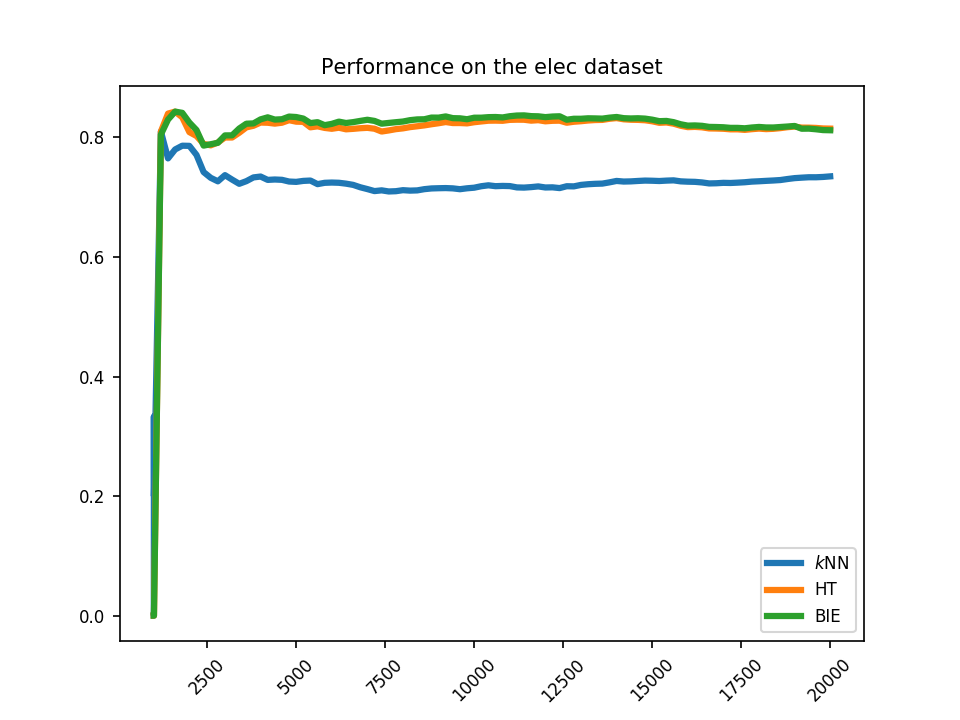

write out to elec ....pdf


In [12]:
import pandas as pd
from matplotlib.pyplot import *

dataset = "elec"

df = pd.read_csv('result_'+dataset+'.csv', comment='#')
ax = df.plot(x="id", y=["mean_acc_[M0]","mean_acc_[M1]","mean_acc_[M2]"], rot=45, linewidth=3, title=dataset)
#ax = df.plot(x="id", y=["current_acc_[M0]", "current_acc_[M1]", "current_acc_[M2]"], rot=30, linewidth=3, title=dataset)
#ax = df.plot(x="id", y=["mean_kappa_[M0]","mean_kappa_[M1]","mean_kappa_[M2]"], rot=45, linewidth=3, title=dataset)
#ax = df.plot(x="id", y=["current_kappa_[M0]", "current_kappa_[M1]", "current_kappa_[M2]"], rot=30, linewidth=3, title=dataset)
ax.set_xlabel("")
ax.set_title("Performance on the %s dataset" % dataset)
ax.legend([r"$k$NN", "HT", "BIE"], loc='best')
print("write out to %s ..." % dataset+".pdf")
savefig("result_"+dataset+".pdf")
show()

## Deliverables

You should submit:
1. The Jupyter Notebook 
2. `html` version of notebook (go to: `File/Download as/HTML`), with visible outputs of your code

in a compressed file (`.zip`, `.rar`, `tar.gz`...), and compressed file should be named: `firstname_lastname_lab2.zip`